In [1]:
from datasets import load_dataset
import pandas as pd
import numpy as np

In [2]:
# this cell may take up to 30 seconds to run to convert the Hugginface Dataset class to Pandas DataFrame for better EDA

HF_SPOTIFY_DATASET_PATH = "maharshipandya/spotify-tracks-dataset"
# https://huggingface.co/datasets/maharshipandya/spotify-tracks-dataset

ds = load_dataset(HF_SPOTIFY_DATASET_PATH) #only has 'train' split as key
df = pd.DataFrame(ds["train"]).drop(columns=['Unnamed: 0'])

print(df.shape)
df.head()

(114000, 20)


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [3]:
# encode track_genre into int
df['track_genre'] = df['track_genre'].astype('category').cat.codes

<Axes: title={'center': 'Correlation with Genre'}>

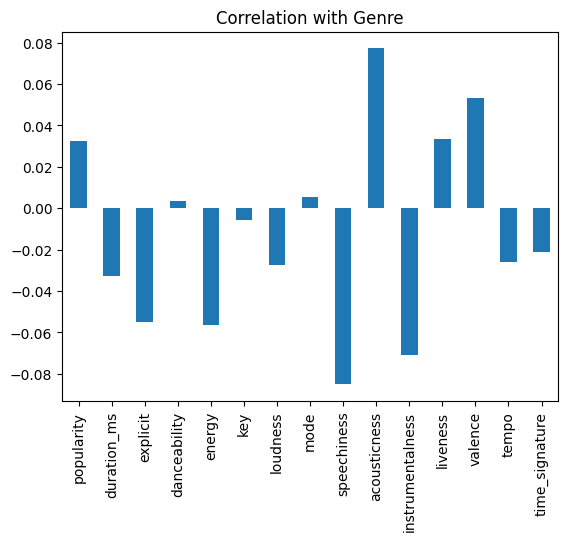

In [4]:
# discover feature correlation with genre
df.corr(numeric_only=True)['track_genre'].drop('track_genre').plot(kind='bar', title="Correlation with Genre")

In [5]:
# goal is to predict the genre
y = df["track_genre"]

# we decided to drop text identifiers such as album, artist, etc. and consider the most relevant characteristics such as
# danceability, energy, loudness, etc. because genres may differ most in these categories
# ex: edm is high energy, lofi is low energy
relevant_features = ['popularity', 'explicit', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']

# Select only the relevant features
X = df[relevant_features]
X.head()

,popularity,explicit,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
0,73,False,0.4610,-6.746,0.1430,0.0322,0.000001,0.3580,0.715
1,55,False,0.1660,-17.235,0.0763,0.9240,0.000006,0.1010,0.267
2,57,False,0.3590,-9.734,0.0557,0.2100,0.000000,0.1170,0.120
3,71,False,0.0596,-18.515,0.0363,0.9050,0.000071,0.1320,0.143
4,82,False,0.4430,-9.681,0.0526,0.4690,0.000000,0.0829,0.167


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# divide into train (60%) and testval (40%)
X_train, X_testval, y_train, y_testval = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Second split: divide testval into val (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_testval, y_testval, test_size=0.5, random_state=42
)


# scale the data since they are on different scales
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Implementing a multi-layer perceptron

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# First convert your numpy data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)

y_train_tensor = torch.LongTensor(y_train.values)
y_val_tensor = torch.LongTensor(y_val.values)
y_test_tensor = torch.LongTensor(y_test.values)

# Create dataset and dataloader objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100)
test_loader = DataLoader(test_dataset, batch_size=100)

In [8]:
from torch import nn, optim
import torch
# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [9]:
# Initialize model, loss function, and optimizer
model = NeuralNetwork(num_features=X_train.shape[1], num_classes=len(np.unique(y_train)))
loss_fn  = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [10]:
#define train and test functions

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    total_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        if batch % 200 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    total_loss /= num_batches
    correct /= size
    return total_loss, correct

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return test_loss, correct

In [11]:
# Training loop
epochs = 100
best_accuracy = 0
res = 0
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    # Get training metrics
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Get validation metrics
    val_loss, val_acc = test(val_loader, model, loss_fn)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    # Save best model
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        res = val_loss

print("Done!")

print(f"best accuracy: {best_accuracy}, corresponding loss: {res}")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 17.5%, Avg loss: 3.395976
Epoch 2
-------------------------------
Test Error: 
 Accuracy: 19.6%, Avg loss: 3.276628
Epoch 3
-------------------------------
Test Error: 
 Accuracy: 20.3%, Avg loss: 3.230943
Epoch 4
-------------------------------
Test Error: 
 Accuracy: 21.4%, Avg loss: 3.183272
Epoch 5
-------------------------------
Test Error: 
 Accuracy: 21.2%, Avg loss: 3.147580
Epoch 6
-------------------------------
Test Error: 
 Accuracy: 21.9%, Avg loss: 3.121983
Epoch 7
-------------------------------
Test Error: 
 Accuracy: 22.3%, Avg loss: 3.084738
Epoch 8
-------------------------------
Test Error: 
 Accuracy: 22.8%, Avg loss: 3.068267
Epoch 9
-------------------------------
Test Error: 
 Accuracy: 22.6%, Avg loss: 3.056887
Epoch 10
-------------------------------
Test Error: 
 Accuracy: 23.1%, Avg loss: 3.038571
Epoch 11
-------------------------------
Test Error: 
 Accuracy: 23.5%, Avg loss: 3.022442
Epoch 12

## Evaluating the neural network performance

In [12]:
train_losses

[3.6778168022981164,
 3.3094798817969204,
 3.223809059948949,
 3.168818450113486,
 3.1259012542969997,
 3.091261497715063,
 3.060341996059083,
 3.033178843601405,
 3.012693018941154,
 2.9931004580698515,
 2.977663923425284,
 2.9649525772758394,
 2.9556464671391494,
 2.944341269850034,
 2.9352536055079677,
 2.9303853097017747,
 2.924224972027784,
 2.916237091460423,
 2.911039384136423,
 2.9053894598581635,
 2.9014001251661288,
 2.8976585833649886,
 2.8940177490139565,
 2.889880279351396,
 2.8868975451118066,
 2.8844463612601072,
 2.8822703870416384,
 2.8777219071025737,
 2.876958337443614,
 2.874401945468278,
 2.8729958150819033,
 2.8707302181344283,
 2.8693042177903023,
 2.867689695623186,
 2.865045057751282,
 2.8647712894350463,
 2.8633355456486083,
 2.8598992183194523,
 2.8591012783914977,
 2.859448260382602,
 2.858652618893406,
 2.8558591618175395,
 2.8548121222278526,
 2.855355349549076,
 2.8540072221505013,
 2.85315447871448,
 2.8514939051622537,
 2.8513457559005557,
 2.8495947031

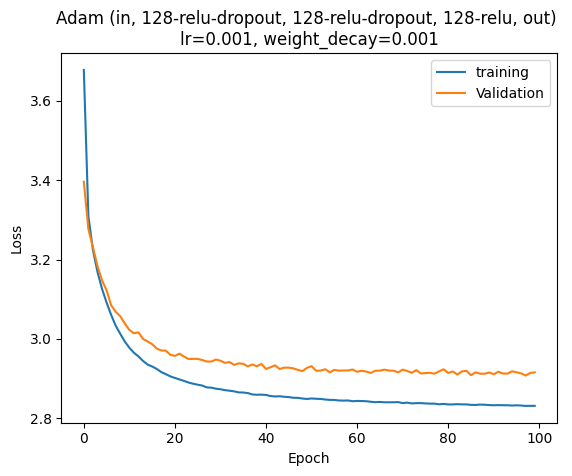

In [13]:
import matplotlib.pyplot as plt

plt.plot(range(epochs), train_losses, label="training")
plt.plot(range(epochs), val_losses, label="Validation")
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title("Adam (in, 128-relu-dropout, 128-relu-dropout, 128-relu, out) \nlr=0.001, weight_decay=0.001")
plt.legend()

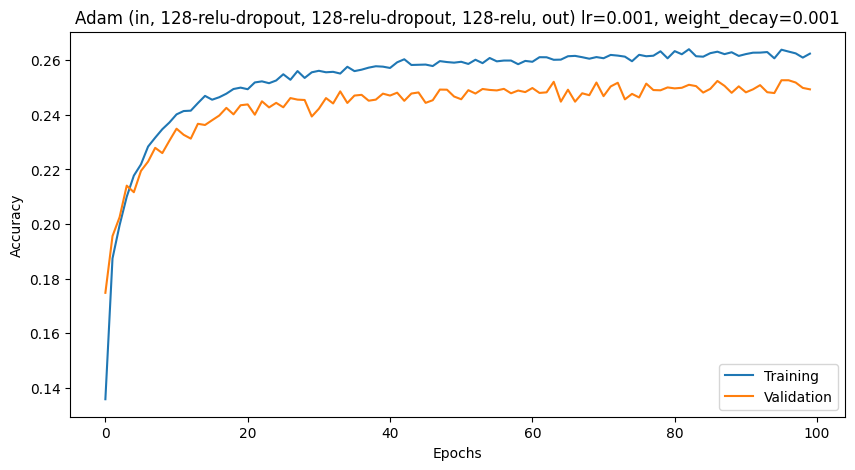

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_accuracies, label='Training')
plt.plot(range(epochs), val_accuracies, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title("Adam (in, 128-relu-dropout, 128-relu-dropout, 128-relu, out) lr=0.001, weight_decay=0.001")
plt.legend(loc='lower right')